## **Imports**

In [220]:
from matplotlib import cm

import math

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import time


import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy
import seaborn as sns

## **Optims**

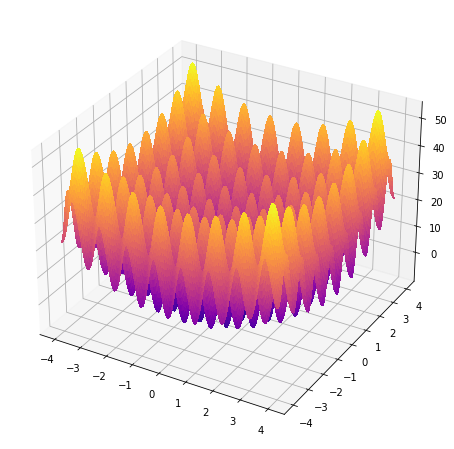

In [2]:
def rastrigin(*X , **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])


X = torch.linspace(-4, 4, 200)    
Y = torch.linspace(-4, 4, 200)    

X, Y = np.meshgrid(X, Y)

Z = rastrigin(X , Y)

fig = plt.figure(figsize=(10 , 8))
ax = plt.subplot(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False);  

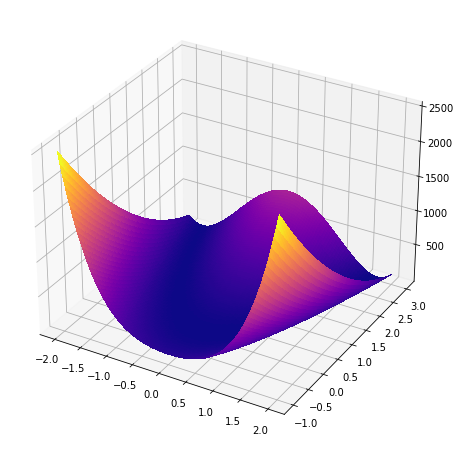

In [3]:
def Rosen(x , y):
    
    return (1-x)**2 + 100. * (y-x**2)**2


x = torch.linspace(-2., 2., 100)
y = torch.linspace(-1., 3., 100)
X, Y = np.meshgrid(x,y)

Z = Rosen(X , Y)

fig = plt.figure(figsize=(10 , 8))
ax = plt.subplot(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False);  

In [134]:
def gradient_descent(func, xi,yi, eta, N):
    xis = []
    yis = []
    zis = []

    
    for iter in range(N):
        func(xi,yi).backward()

        xi.data -= eta * xi.grad
        yi.data -= eta * yi.grad
        
        xi.grad.zero_()
        yi.grad.zero_()
        
        xi_copy = xi.clone()
        yi_copy = yi.clone()
        
        
        xis.append(xi_copy.data)
        yis.append(yi_copy.data)
        zis.append(func(xi_copy.data , yi_copy.data))

        
    return xis , yis , zis

In [135]:
def gradient_descent_with_momentum(func, xi,yi, eta, N , beta=0.9):
    xis = []
    yis = []
    zis = []
    mt0x = 0
    mt0y = 0
    
    for iter in range(N):
        func(xi,yi).backward()
        
        mt1x = beta*mt0x + (1-beta)*xi.grad
        mt1y = beta*mt0y + (1-beta)*yi.grad
        
        xi.data -= eta * mt1x
        yi.data -= eta * mt1y
        
        xi.grad.zero_()
        yi.grad.zero_()
        
        xi_copy = xi.clone()
        yi_copy = yi.clone()
        
        
        xis.append(xi_copy.data)
        yis.append(yi_copy.data)
        zis.append(func(xi_copy.data , yi_copy.data))

        mt0x = mt1x
        mt0y = mt1y
        
    return xis , yis , zis

In [160]:
def adagrad(func, xi ,yi , eta, N , eps=0.00001):
    xis = []
    yis = []
    zis = []
    vt0x = 0
    vt0y = 0
    
    for iter in range(N):
        func(xi,yi).backward()
        
        vt1x = vt0x + xi.grad**2
        vt1y = vt0y + yi.grad**2

        xi.data -= eta * xi.grad / torch.sqrt(vt1x) + eps
        yi.data -= eta * yi.grad / torch.sqrt(vt1y) + eps
        
        
        xi.grad.zero_()
        yi.grad.zero_()

        xi_copy = xi.clone()
        yi_copy = yi.clone()
        
        xis.append(xi_copy.data)
        yis.append(yi_copy.data)
        zis.append(func(xi_copy.data , yi_copy.data))

        vt0x = vt1x
        vt0y = vt1y

    return xis , yis , zis

In [181]:
def RMSProb(func, xi ,yi , eta, N , beta2=0.999 , eps=0.00001):
    xis = []
    yis = []
    zis = []
    vt0x = 0
    vt0y = 0
    
    for iter in range(N):
        func(xi,yi).backward()
        
        vt1x = (beta2 * vt0x) + (1-beta2) * xi.grad**2
        vt1y = (beta2 * vt0y) + (1-beta2) * yi.grad**2


        xi.data -= eta * xi.grad / torch.sqrt(vt1x) + eps
        yi.data -= eta * yi.grad / torch.sqrt(vt1y) + eps
        
        
        xi.grad.zero_()
        yi.grad.zero_()

        xi_copy = xi.clone()
        yi_copy = yi.clone()
        
        xis.append(xi_copy.data)
        yis.append(yi_copy.data)
        zis.append(func(xi_copy.data , yi_copy.data))

        vt0x = vt1x
        vt0y = vt1y

    return xis , yis , zis

In [209]:
def adam(func, xi ,yi , eta, N ,beta=0.9 , beta2=0.999 , eps=0.00001):
    xis = []
    yis = []
    zis = []
    vt0x = 0
    vt0y = 0
    mt0x = 0
    mt0y = 0
    t = 0
    for iter in range(N):
        func(xi,yi).backward()
        
        mt1x = beta*mt0x + (1-beta)*xi.grad
        mt1y = beta*mt0y + (1-beta)*yi.grad
        
        vt1x = (beta2 * vt0x) + (1-beta2) * xi.grad**2
        vt1y = (beta2 * vt0y) + (1-beta2) * yi.grad**2

        t += 1
        
        mx_prim = mt1x / (1 - beta**t)
        my_prim = mt1y / (1 - beta**t)
        
        vx_prim = vt1x / (1 - beta2**t)
        vy_prim = vt1y / (1 - beta2**t)
        
        
        
        xi.data -= eta * mx_prim / torch.sqrt(vx_prim) + eps
        yi.data -= eta * my_prim / torch.sqrt(vy_prim) + eps
        
        
        xi.grad.zero_()
        yi.grad.zero_()

        xi_copy = xi.clone()
        yi_copy = yi.clone()
        
        xis.append(xi_copy.data)
        yis.append(yi_copy.data)
        zis.append(func(xi_copy.data , yi_copy.data))

        vt0x = vt1x
        vt0y = vt1y
        mt0x = mt1x
        mt0y = mt1y

    return xis , yis , zis

In [5]:
def rastrigin(*X , **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * torch.cos(2 * math.pi * x)) for x in X])

## **Gradient Descent**

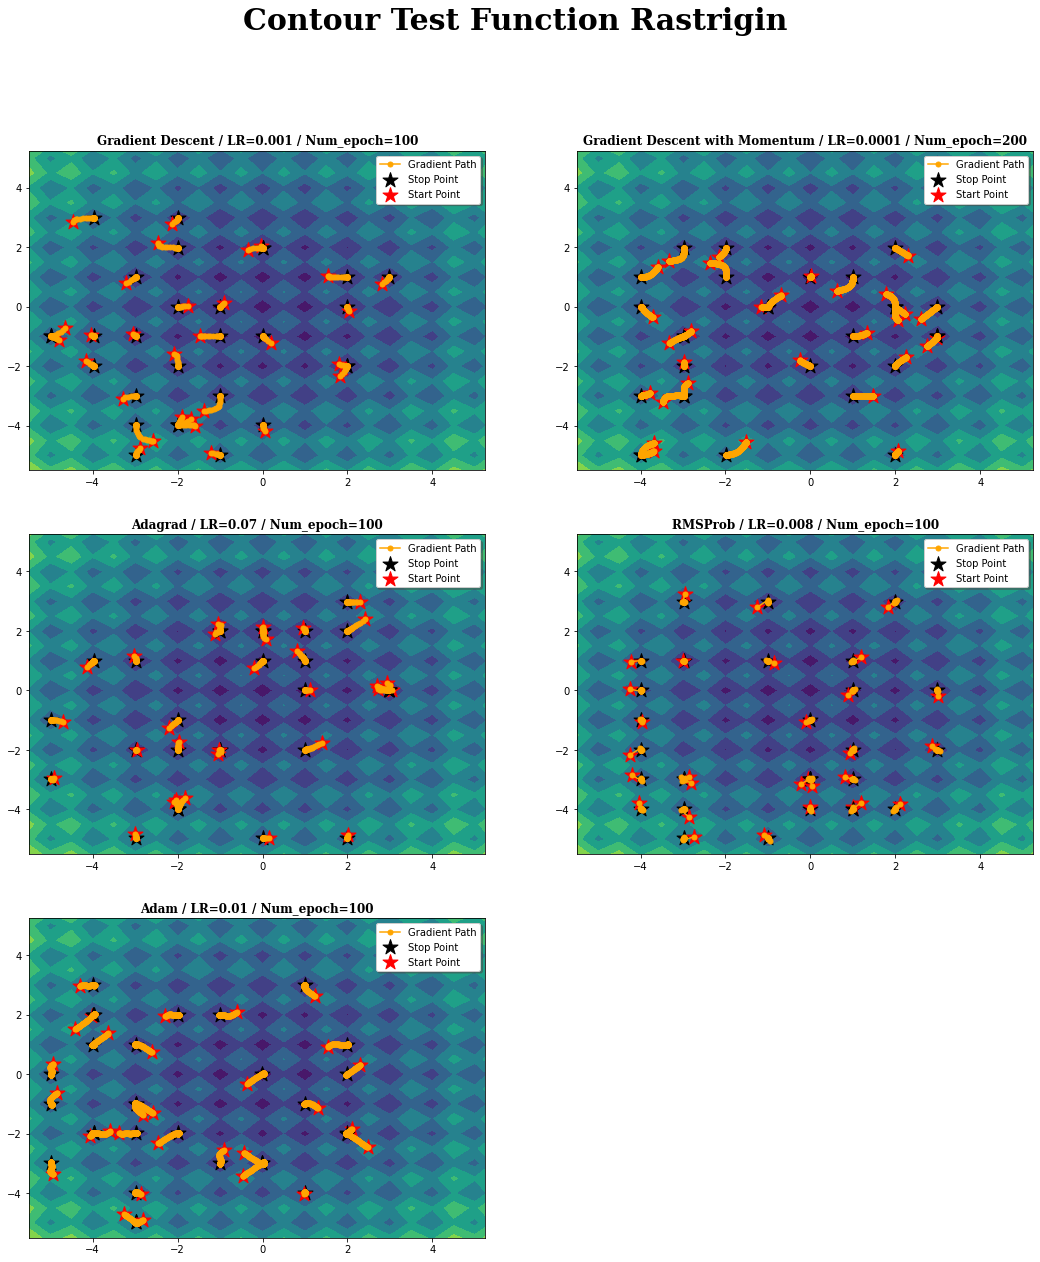

In [274]:
x1 = torch.arange(-5.5, 5.5, 0.25)
x2 = torch.arange(-5.5, 5.5, 0.25)
X1, X2 = torch.meshgrid(x1, x2)
fig = plt.figure(figsize=(18,20))



ax1 = fig.add_subplot(321);
ax1.contourf(X1 , X2 , rastrigin(X1 , X2));
eta = 0.001
N = 100
a = 8 * np.random.rand(30) - 5
b = 8 * np.random.rand(30) - 5
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent(rastrigin , x , y , eta, N)
    line1, = ax1.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax1.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax1.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent / LR={eta} / Num_epoch={N}' , fontfamily='Serif',fontweight='bold');



ax2 = fig.add_subplot(322);
ax2.contourf(X1 , X2 , rastrigin(X1 , X2));
eta = 0.0001
N = 200
a = 8 * np.random.rand(30) - 5
b = 8 * np.random.rand(30) - 5
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent_with_momentum(rastrigin , x , y , eta, N)
    line1, = ax2.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax2.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax2.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent with Momentum / LR={eta} / Num_epoch={N}' , fontfamily='Serif',fontweight='bold');



ax3 = fig.add_subplot(323);
ax3.contourf(X1 , X2 , rastrigin(X1 , X2));
eta = 0.07
N = 100
a = 8 * np.random.rand(30) - 5
b = 8 * np.random.rand(30) - 5
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adagrad(rastrigin , x , y , eta, N)
    line1, = ax3.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax3.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax3.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adagrad / LR={eta} / Num_epoch={N}' , fontfamily='Serif',fontweight='bold');



ax4 = fig.add_subplot(324);
ax4.contourf(X1 , X2 , rastrigin(X1 , X2));
eta = 0.008
N = 100
a = 8 * np.random.rand(30) - 5
b = 8 * np.random.rand(30) - 5
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = RMSProb(rastrigin , x , y , eta, N)
    line1, = ax4.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax4.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax4.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'RMSProb / LR={eta} / Num_epoch={N}' , fontfamily='Serif',fontweight='bold');



ax5 = fig.add_subplot(325);
ax5.contourf(X1 , X2 , rastrigin(X1 , X2));
eta = 0.01
N = 100
a = 8 * np.random.rand(30) - 5
b = 8 * np.random.rand(30) - 5
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adam(rastrigin , x , y , eta, N)
    line1, = ax5.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax5.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax5.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adam / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');
plt.suptitle(f'Contour Test Function Rastrigin', fontfamily='Serif' , fontsize=30 , fontweight='bold');
plt.savefig('plot1')

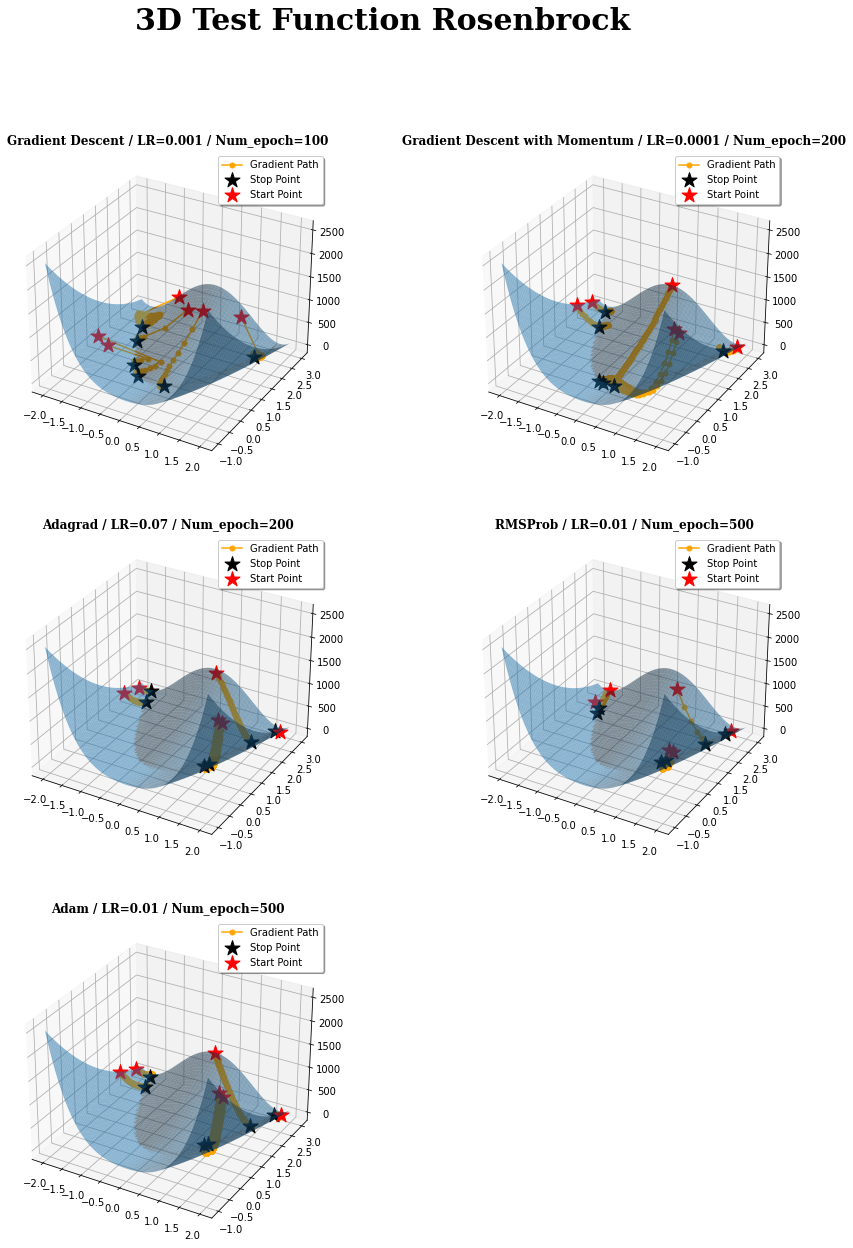

In [275]:
x1 = torch.linspace(-2., 2., 100)
x2 = torch.linspace(-1., 3., 100)
X1, X2 = torch.meshgrid(x1, x2)
fig = plt.figure(figsize=(15,20))



ax1 = fig.add_subplot(321, projection='3d');
ax1.plot_surface(X1 , X2 , Rosen(X1 , X2) , alpha=0.5);
eta = 0.001
N = 100
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent(Rosen , x , y , eta, N)
    line1, = ax1.plot(xs , ys , zs , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax1.scatter(xs[-1] , ys[-1] , zs[-1] ,  marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax1.scatter(xs[0] , ys[0] , zs[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax2 = fig.add_subplot(322 , projection='3d');
ax2.plot_surface(X1 , X2 , Rosen(X1 , X2) , alpha=0.5);
eta = 0.0001
N = 200
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent_with_momentum(Rosen , x , y , eta, N)
    line1, = ax2.plot(xs , ys , zs , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax2.scatter(xs[-1] , ys[-1] , zs[-1] ,  marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax2.scatter(xs[0] , ys[0] , zs[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent with Momentum / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax3 = fig.add_subplot(323,projection='3d');
ax3.plot_surface(X1 , X2 , Rosen(X1 , X2) , alpha=0.5);
eta = 0.07
N = 200
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adagrad(Rosen , x , y , eta, N)
    line1, = ax3.plot(xs , ys , zs , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax3.scatter(xs[-1] , ys[-1] , zs[-1] ,  marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax3.scatter(xs[0] , ys[0] , zs[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adagrad / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax4 = fig.add_subplot(324,projection='3d');
ax4.plot_surface(X1 , X2 , Rosen(X1 , X2) , alpha=0.5);
eta = 0.01
N = 500


a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]

for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = RMSProb(Rosen , x , y , eta, N)
    line1, = ax4.plot(xs , ys , zs , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax4.scatter(xs[-1] , ys[-1] , zs[-1] ,  marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax4.scatter(xs[0] , ys[0] , zs[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'RMSProb / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax5 = fig.add_subplot(325,projection='3d');
ax5.plot_surface(X1 , X2 , Rosen(X1 , X2) , alpha=0.5);
eta = 0.01
N = 500
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adam(Rosen , x , y , eta, N)
    line1, = ax5.plot(xs , ys , zs , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax5.scatter(xs[-1] , ys[-1] , zs[-1] ,  marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax5.scatter(xs[0] , ys[0] , zs[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adam / LR={eta} / Num_epoch={N}' , fontfamily='Serif',fontweight='bold');
plt.suptitle(f'3D Test Function Rosenbrock', fontfamily='Serif' , fontsize=30 , fontweight='bold');
plt.savefig('plot2')

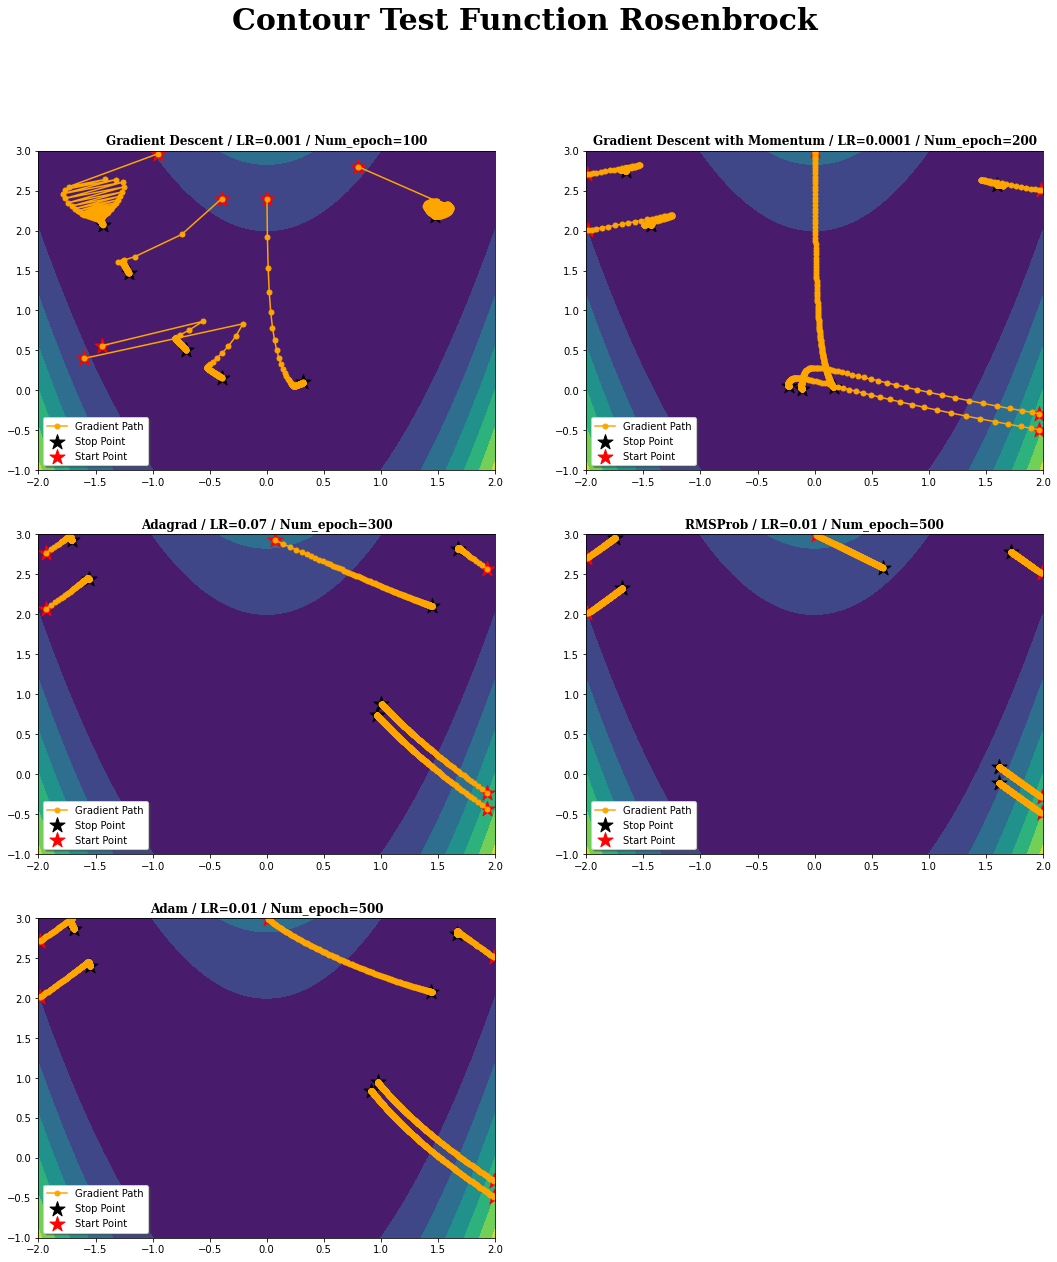

In [276]:
x1 = torch.linspace(-2., 2., 100)
x2 = torch.linspace(-1., 3., 100)
X1, X2 = torch.meshgrid(x1, x2)
fig = plt.figure(figsize=(18,20))




ax1 = fig.add_subplot(321);
ax1.contourf(X1 , X2 , Rosen(X1 , X2));
eta = 0.001
N = 100
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent(Rosen , x , y , eta, N)
    line1, = ax1.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax1.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax1.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax2 = fig.add_subplot(322);
ax2.contourf(X1 , X2 , Rosen(X1 , X2));
eta = 0.0001
N = 200
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = gradient_descent_with_momentum(Rosen , x , y , eta, N)
    line1, = ax2.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax2.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax2.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Gradient Descent with Momentum / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');




ax3 = fig.add_subplot(323);
ax3.contourf(X1 , X2 , Rosen(X1 , X2));
eta = 0.07
N = 300
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adagrad(Rosen , x , y , eta, N)
    line1, = ax3.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax3.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax3.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adagrad / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax4 = fig.add_subplot(324);
ax4.contourf(X1 , X2 , Rosen(X1 , X2));
eta = 0.01
N = 500
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adagrad(Rosen , x , y , eta, N)
    line1, = ax4.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax4.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax4.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'RMSProb / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');



ax5 = fig.add_subplot(325);
ax5.contourf(X1 , X2 , Rosen(X1 , X2));
eta = 0.01
N = 500
a = [2. , 2. , 0. , -2. , -2. , 2.]
b = [-.5 , 2.5 , 3. , 2.7 , 2. , -0.3]
for x , y in zip(a , b):
    x = torch.tensor(x , requires_grad=True)
    y = torch.tensor(y , requires_grad=True)
    xs , ys , zs = adam(Rosen , x , y , eta, N)
    line1, = ax5.plot(xs , ys , c='orange' , marker="o" , ms=5 , label='Gradient Path');
    line2 = ax5.scatter(xs[-1] , ys[-1] , marker='*' , color='k' , s=250 , label='Stop Point');
    line3 = ax5.scatter(xs[0] , ys[0] , marker='*' , color='r' , s=250 , label='Start Point');
plt.legend(handles=[line1, line2, line3] , shadow=True);
plt.title(f'Adam / LR={eta} / Num_epoch={N}' , fontfamily='Serif' , fontweight='bold');
plt.suptitle(f'Contour Test Function Rosenbrock', fontfamily='Serif' , fontsize=30 , fontweight='bold');
plt.savefig('plot3')